# Otimiza√ß√£o com Algoritmos Gen√©ticos

Neste notebook, exploramos a aplica√ß√£o de **Algoritmos Gen√©ticos (AGs)** para resolver problemas de otimiza√ß√£o unidimensional. Atrav√©s de duas implementa√ß√µes distintas ‚Äî uma manual e outra utilizando a biblioteca **DEAP (Distributed Evolutionary Algorithms in Python)** ‚Äî investigamos o comportamento e a efici√™ncia dos AGs na busca pela melhor solu√ß√£o de uma fun√ß√£o real.

A fun√ß√£o objetivo considerada √©:

$$
f(x) = \frac{\sin(x + 10)}{x + 10} + \frac{\sin(x - 10)}{x - 10}
$$

com a conven√ß√£o de que $\frac{\sin(0)}{0} = 1$, ou seja, o valor da fun√ß√£o em $x = -10$ e $x = 10$ √© definido como 1. Essa fun√ß√£o apresenta dois picos principais, tornando-se um bom exemplo para analisar a **explora√ß√£o** e a **explora√ß√£o local** em algoritmos evolutivos.

Ao longo do notebook, visualizamos:

- A evolu√ß√£o da popula√ß√£o ao longo das gera√ß√µes;
- A converg√™ncia dos melhores indiv√≠duos;
- A compara√ß√£o entre as abordagens de implementa√ß√£o.


## Implementa√ß√£o sem uso de libraries

Nesta implementa√ß√£o, utilizamos recombina√ß√£o e muta√ß√£o simplificadas, veja as descri√ß√µes ap√≥s o c√≥digo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

def run_ga(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval

    # Fun√ß√£o de fitness (valor da fun√ß√£o)
    def fitness(individual: float) -> float:
        return function(individual)

    # Sele√ß√£o por torneio
    def tournament_selection(
        population: np.ndarray, fitness_values: np.ndarray, k: int = 3
    ) -> float:
        selected_indices = np.random.choice(len(population), size=k, replace=False)
        selected_fitness = fitness_values[selected_indices]
        winner_index = selected_indices[np.argmax(selected_fitness)]
        return population[winner_index]

    # Crossover (combina√ß√£o de dois pais)
    def crossover(parent1: float, parent2: float) -> float:
        if np.random.rand() < crossover_rate:
            alpha = np.random.rand()  # Fator de mistura
            child = alpha * parent1 + (1 - alpha) * parent2
        else:
            child = parent1  # Sem crossover, retorna o primeiro pai
        return child

    # Muta√ß√£o (perturba√ß√£o aleat√≥ria)
    def mutate(individual: float) -> float:
        if np.random.rand() < mutation_rate:
            individual += np.random.uniform(-1, 1)  # Perturba√ß√£o aleat√≥ria
            individual = np.clip(individual, LOW, HIGH)  # Garantir que est√° dentro dos limites
        return individual

    # Inicializa√ß√£o da popula√ß√£o
    population: np.ndarray = np.random.uniform(LOW, HIGH, size=(pop_size,))

    # Evolu√ß√£o
    best_fitness_history: list[float] = []
    population_history: list[np.ndarray] = []  # Para armazenar as popula√ß√µes de cada gera√ß√£o

    for generation in range(gen_number):
        # Avaliar fitness da popula√ß√£o
        fitness_values: np.ndarray = np.array([fitness(ind) for ind in population])

        # Guardar o hist√≥rico de fitness
        best_index: int = np.argmax(fitness_values)
        best_individual: float = population[best_index]
        best_fitness: float = fitness_values[best_index]
        best_fitness_history.append(best_fitness)

        # Armazenar a popula√ß√£o atual para visualiza√ß√£o
        population_history.append(population.copy())

        # Sele√ß√£o, crossover e muta√ß√£o
        new_population: list[float] = []

        # Elitismo: manter os melhores indiv√≠duos
        tmp: np.ndarray = fitness_values.copy()
        for _ in range(elitism):
            best_index = np.argmax(tmp)
            best_individual = population[best_index]
            tmp[best_index] = -np.inf
            new_population.append(best_individual)

        # Gerar nova popula√ß√£o
        while len(new_population) < pop_size:
            # Selecionar dois pais
            parent1: float = tournament_selection(population, fitness_values)
            parent2: float = tournament_selection(population, fitness_values)

            # Crossover
            child: float = crossover(parent1, parent2)

            # Muta√ß√£o
            child = mutate(child)

            # Adicionar √† nova popula√ß√£o
            new_population.append(child)

        # Atualizar popula√ß√£o
        population = np.array(new_population)

    # Resultado final
    best_index: int = np.argmax([fitness(ind) for ind in population])
    best_solution: float = population[best_index]
    best_fitness: float = fitness(best_solution)

    print(f"Melhor solu√ß√£o encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as popula√ß√µes em gr√°ficos (3 gr√°ficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals: np.ndarray = np.linspace(LOW, HIGH, 1000)
    y_vals: np.ndarray = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Fun√ß√£o', color='blue')
        plt.scatter(
            population_history[generation], function(population_history[generation]), color='red', label='Popula√ß√£o'
        )
        plt.title(f'Gera√ß√£o {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolu√ß√£o do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Gera√ß√£o', color='green')
    plt.title('Evolu√ß√£o do Fitness')
    plt.xlabel('Gera√ß√£o')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

## üìå **Descri√ß√£o `run_ga`**

### 1. Defini√ß√µes iniciais

- **Fun√ß√£o objetivo (fitness)**:
  $$
  f: \mathbb{R} \to \mathbb{R}, \quad \text{a ser maximizada.}
  $$

- **Intervalo de busca**:
  $$
  I = [L, H] \subset \mathbb{R}, \quad \text{com } L = -20, \, H = 20.
  $$

- **Tamanho da popula√ß√£o**: $N \in \mathbb{N}$

- **N√∫mero de gera√ß√µes**: $G \in \mathbb{N}$

- **Taxa de crossover**: $p_c \in [0,1]$

- **Taxa de muta√ß√£o**: $p_m \in [0,1]$

- **Elitismo**: $e \in \mathbb{N}$, n√∫mero de melhores indiv√≠duos copiados diretamente para a pr√≥xima gera√ß√£o.


### 2. Inicializa√ß√£o da popula√ß√£o

Geramos $N$ indiv√≠duos $\{x_1^0, x_2^0, \dots, x_N^0\} \subset [L, H]$ tais que:

$$
x_i^0 \sim \mathcal{U}(L, H)
$$


### 3. Avalia√ß√£o do fitness

Para cada indiv√≠duo $x_i^t$, calculamos:

$$
f_i^t = f(x_i^t)
$$


### 4. Sele√ß√£o por torneio (k = 3)

Para selecionar um indiv√≠duo:
1. Amostram-se 3 indiv√≠duos aleatoriamente da popula√ß√£o.
2. Seleciona-se aquele com o maior valor de fitness.

Formalmente, dado um conjunto $S \subset \{1, \dots, N\}$, com $|S| = 3$:

$$
x_{\text{sel}} = \arg\max_{i \in S} f(x_i)
$$


### 5. Crossover linear (recombina√ß√£o)

Dado dois pais $x_1, x_2 \in \mathbb{R}$, um novo indiv√≠duo $x_{\text{child}}$ √© gerado por:

$$
x_{\text{child}} = 
\begin{cases}
\alpha x_1 + (1 - \alpha)x_2, & \text{com probabilidade } p_c \\
x_1, & \text{com probabilidade } 1 - p_c
\end{cases}
\quad \text{onde } \alpha \sim \mathcal{U}(0, 1)
$$


### 6. Muta√ß√£o aditiva

Dado um indiv√≠duo $x \in \mathbb{R}$, aplica-se:

$$
x' = 
\begin{cases}
x + \delta, & \text{com probabilidade } p_m \\
x, & \text{com probabilidade } 1 - p_m
\end{cases}
\quad \text{onde } \delta \sim \mathcal{U}(-1, 1)
$$

E ent√£o:

$$
x' \leftarrow \text{clip}(x', L, H)
$$


### 7. Elitismo

Os $e$ indiv√≠duos com maior fitness na gera√ß√£o $t$ s√£o transferidos diretamente para $t+1$:

$$
x_1^{t+1}, x_2^{t+1}, \dots, x_e^{t+1} \in \arg\max_{x \in \{x_i^t\}} f(x)
$$


### 8. Itera√ß√£o

Os passos 3 a 7 s√£o repetidos por $G$ gera√ß√µes, produzindo uma nova popula√ß√£o a cada itera√ß√£o.


### 9. Resultado final

Ao final da √∫ltima gera√ß√£o $G$, retorna-se:

$$
x^* = \arg\max_{x \in \{x_i^G\}} f(x)
$$

Melhor solu√ß√£o encontrada: x = -0.0012581991734693623, f(x) = 0.9999997361558275


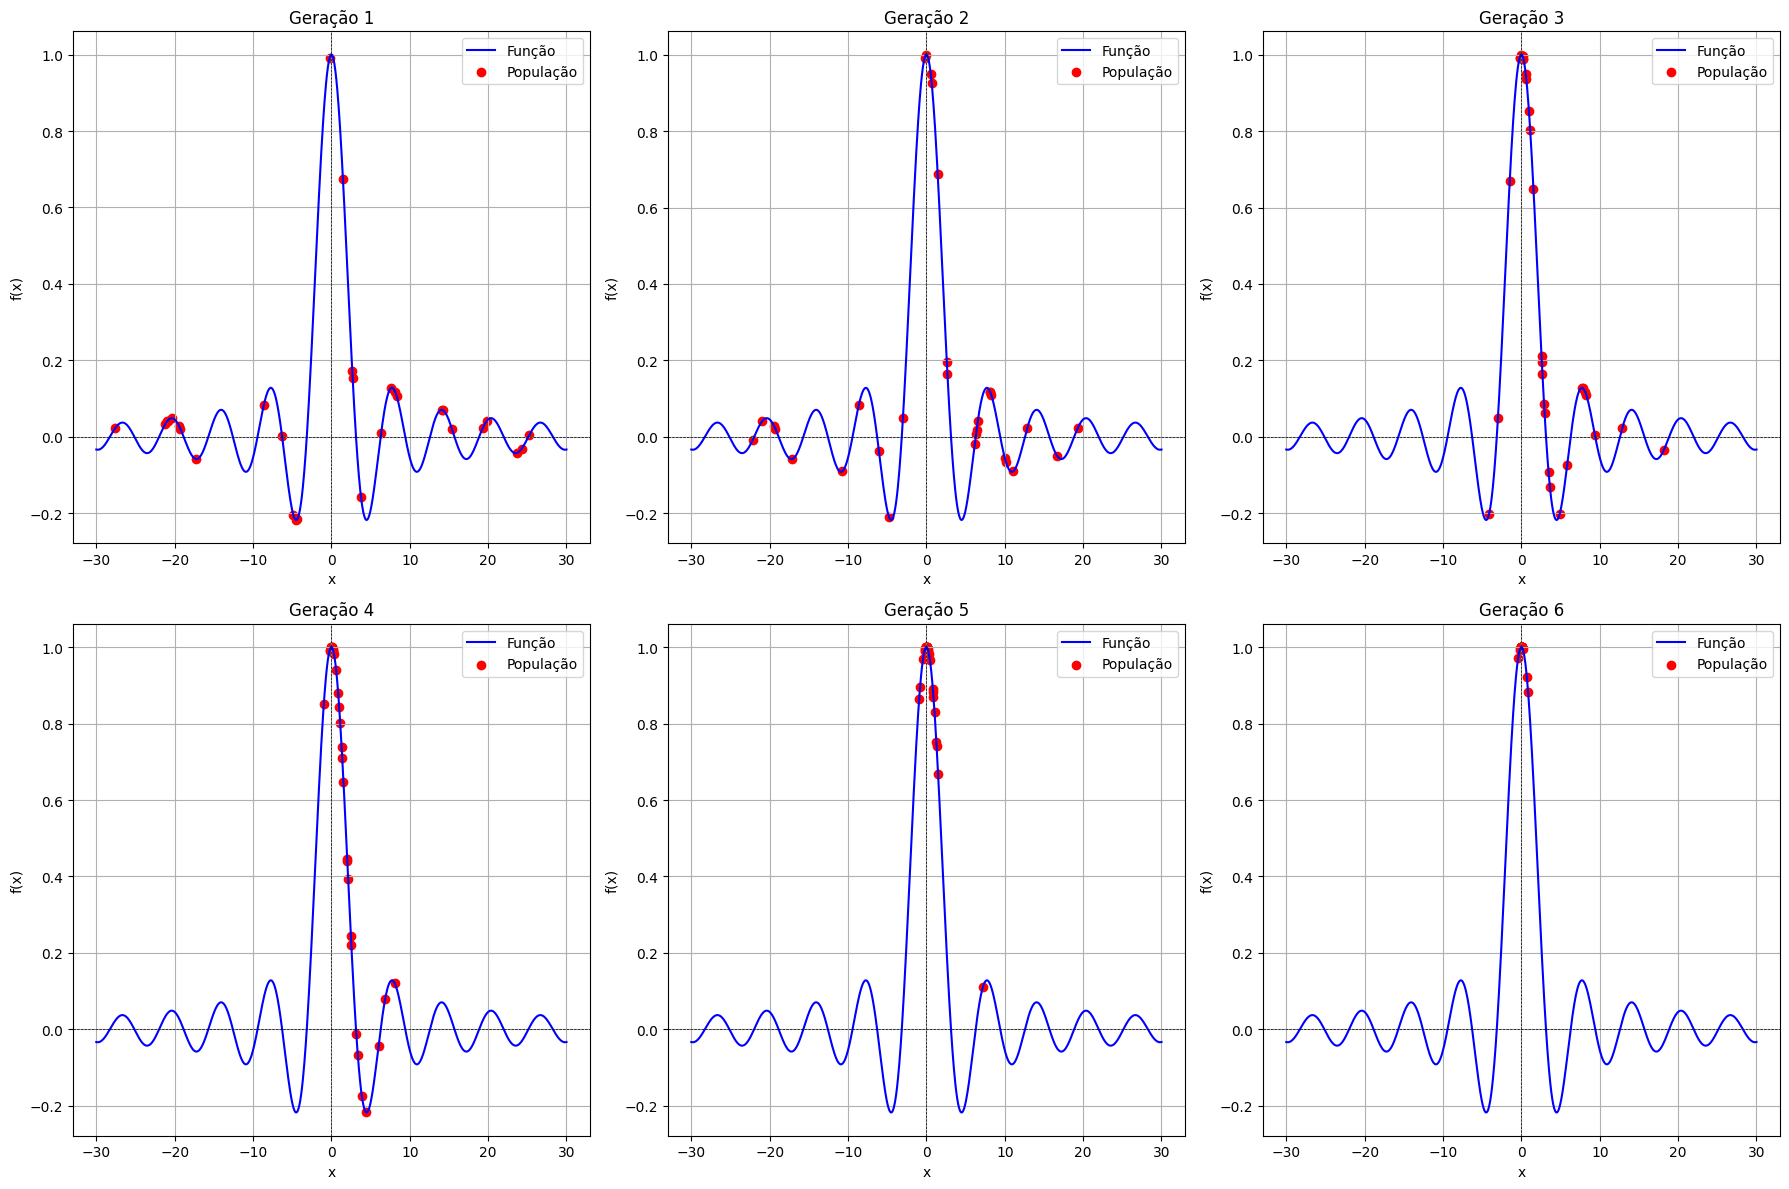

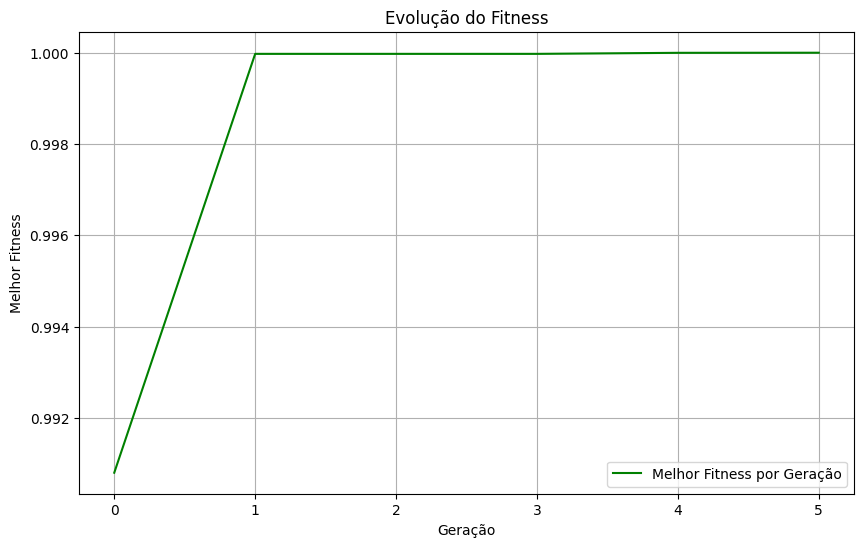

In [2]:
# Defini√ß√£o da fun√ß√£o sinc
def f(x):
    return np.where(x == 0, 1.0, np.sin(x) / x)

run_ga(function=f, interval=[-30, 30])

### Teste com duas sincs

Melhor solu√ß√£o encontrada: x = 10.045991558253977, f(x) = 1.046077809600128


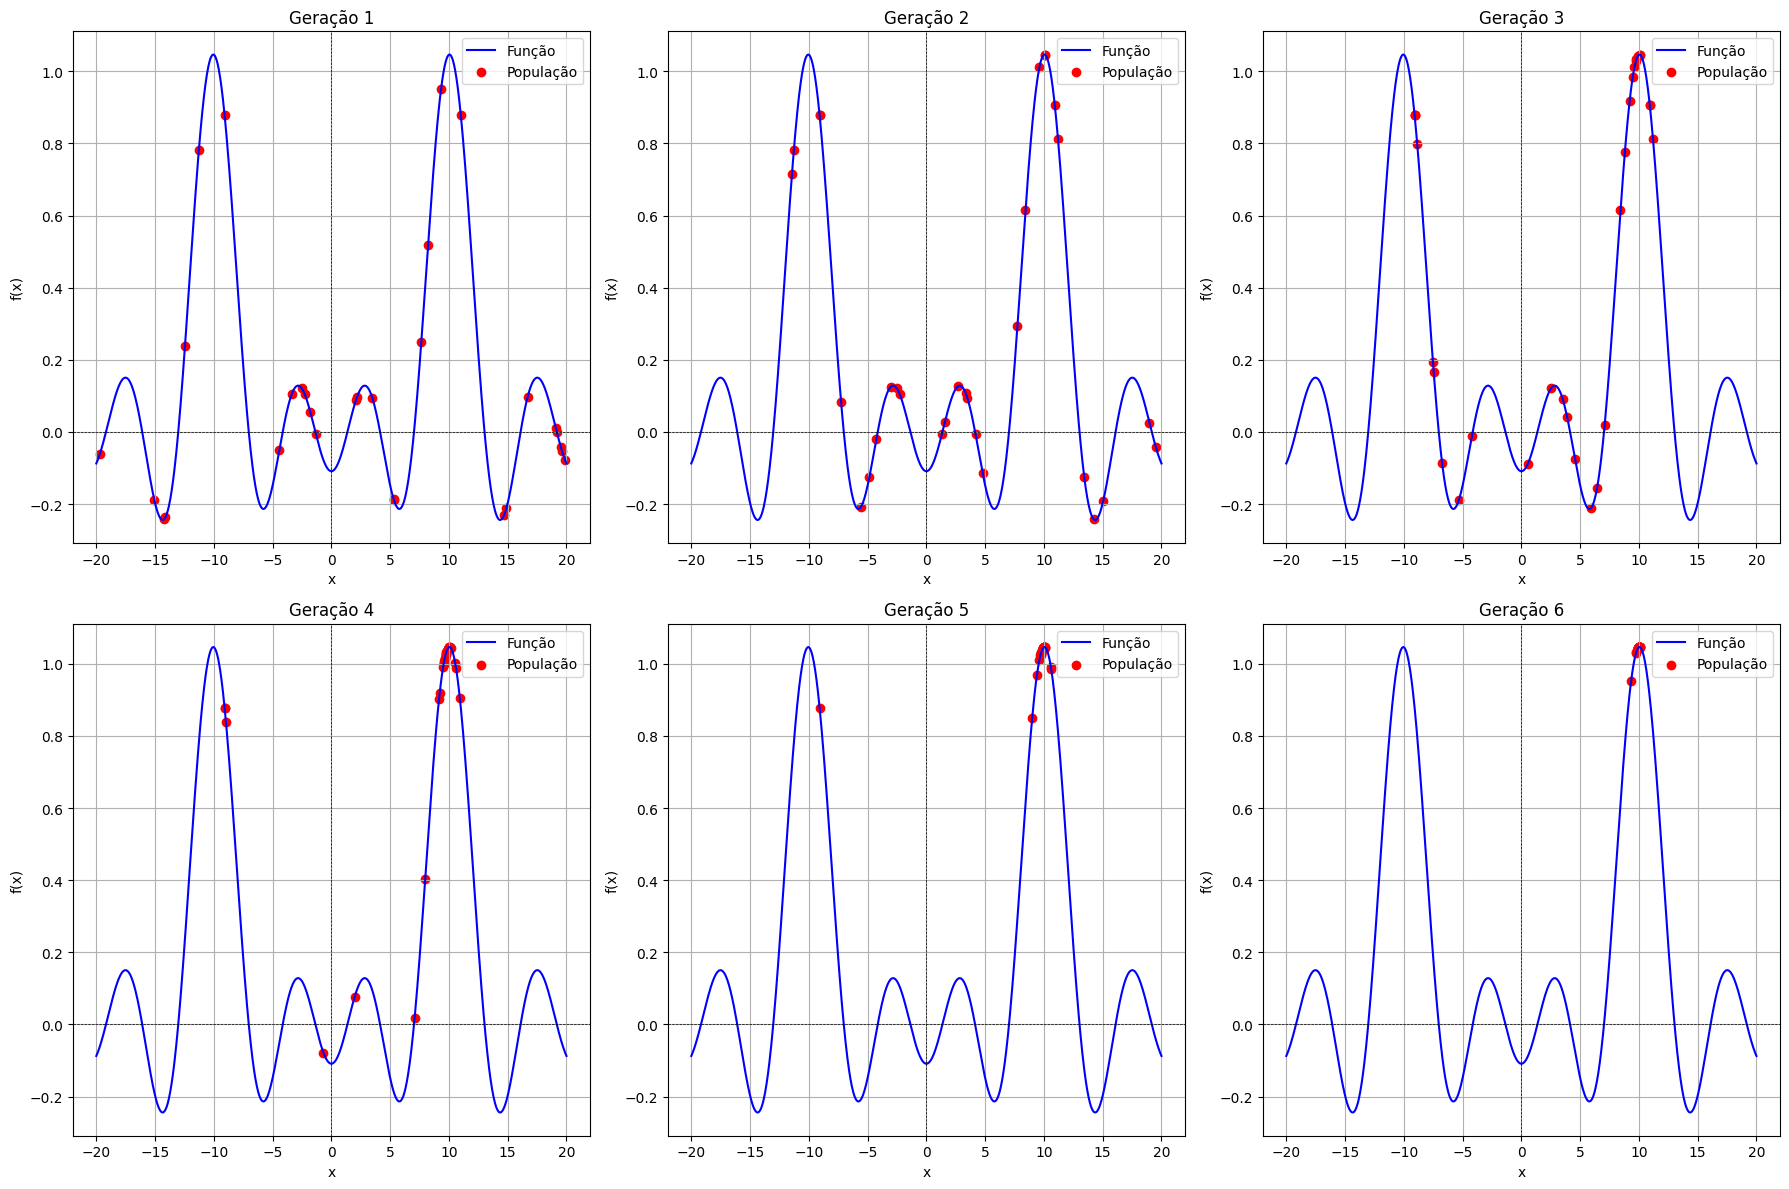

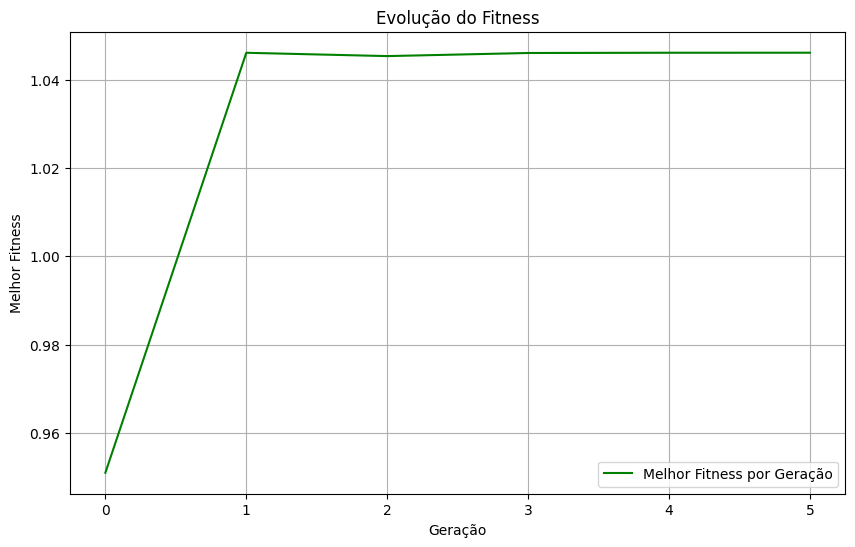

In [3]:
def f(x):
    c1 = 10
    c2 = -10
    a = x+c1
    b = x+c2
    return np.where(x == c1, 1.0, np.sin(a) / a) + np.where(x == c2, 1.0, np.sin(b) / b)

run_ga(function=f, interval=[-20, 20])

## Implementa√ß√£o com uso da library DEAP

Nesta implementa√ß√£o, seguimos o mesmo fluxo proposto na anterior, por√©m, utilizando operadores de recombina√ß√£o e muta√ß√£o um pouco mais sofisticados.

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
from typing import Callable

def run_ga_deap(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval
    
    # Resetar o criador para evitar erros ao executar a fun√ß√£o m√∫ltiplas vezes
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual
    
    # Definir tipos de indiv√≠duos e popula√ß√µes
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar a fun√ß√£o
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Inicializar a toolbox
    toolbox = base.Toolbox()
    
    # Registrar fun√ß√µes para criar indiv√≠duos e popula√ß√£o
    toolbox.register("attr_float", random.uniform, LOW, HIGH)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Fun√ß√£o de fitness (valor da fun√ß√£o)
    def fitness_func(individual):
        return function(individual[0]),  # DEAP requer que a fun√ß√£o de fitness retorne uma tupla

    # Registrar operadores gen√©ticos
    toolbox.register("evaluate", fitness_func)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover blend
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=(HIGH-LOW)/10, indpb=1.0)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Criar popula√ß√£o inicial
    population = toolbox.population(n=pop_size)
    
    # Avaliar a popula√ß√£o inicial
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    # Hall of Fame para elitismo (s√≥ criar se realmente precisar)
    hof = tools.HallOfFame(max(1, elitism)) if elitism > 0 else None
    
    # Hist√≥rico para visualiza√ß√£o
    best_fitness_history = []
    population_history = []

    # Evolu√ß√£o
    for gen in range(gen_number):
        # Armazenar popula√ß√£o para visualiza√ß√£o
        population_history.append([ind[0] for ind in population])
        
        # Encontrar o melhor indiv√≠duo desta gera√ß√£o
        best_ind = tools.selBest(population, 1)[0]
        best_fitness_history.append(best_ind.fitness.values[0])
        
        # Atualizar Hall of Fame (apenas se estiver usando elitismo)
        if hof is not None:
            hof.update(population)
        
        # Selecionar indiv√≠duos para a pr√≥xima gera√ß√£o
        offspring = toolbox.select(population, pop_size)
        offspring = list(map(toolbox.clone, offspring))
        
        # Aplicar crossover
        for i in range(0, len(offspring), 2):
            if i + 1 < len(offspring) and random.random() < crossover_rate:
                toolbox.mate(offspring[i], offspring[i + 1])
                del offspring[i].fitness.values
                del offspring[i + 1].fitness.values

        # Aplicar muta√ß√£o
        for i in range(len(offspring)):
            if random.random() < mutation_rate:
                toolbox.mutate(offspring[i])
                del offspring[i].fitness.values
        
        # Garantir que os indiv√≠duos estejam dentro dos limites
        for ind in offspring:
            if not ind.fitness.valid:
                ind[0] = np.clip(ind[0], LOW, HIGH)
        
        # Avaliar os indiv√≠duos com fitness inv√°lido
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Substituir a popula√ß√£o considerando o elitismo
        if elitism > 0 and hof is not None:
            # Substituir os piores indiv√≠duos pelos elites
            offspring.sort(key=lambda ind: ind.fitness.values[0])
            for i in range(min(len(hof), elitism)):
                if i < len(offspring):
                    offspring[i] = toolbox.clone(hof[i])
        
        # Substituir a popula√ß√£o
        population[:] = offspring
    
    # Obter o melhor indiv√≠duo
    best_ind = tools.selBest(population, 1)[0]
    best_solution = best_ind[0]
    best_fitness = best_ind.fitness.values[0]
    
    print(f"Melhor solu√ß√£o encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as popula√ß√µes em gr√°ficos (3 gr√°ficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals = np.linspace(LOW, HIGH, 1000)
    y_vals = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Fun√ß√£o', color='blue')
        plt.scatter(
            population_history[generation], 
            function(np.array(population_history[generation])), 
            color='red', 
            label='Popula√ß√£o'
        )
        plt.title(f'Gera√ß√£o {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolu√ß√£o do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Gera√ß√£o', color='green')
    plt.title('Evolu√ß√£o do Fitness')
    plt.xlabel('Gera√ß√£o')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

Melhor solu√ß√£o encontrada: x = 10.042561915154716, f(x) = 1.0460735155204448


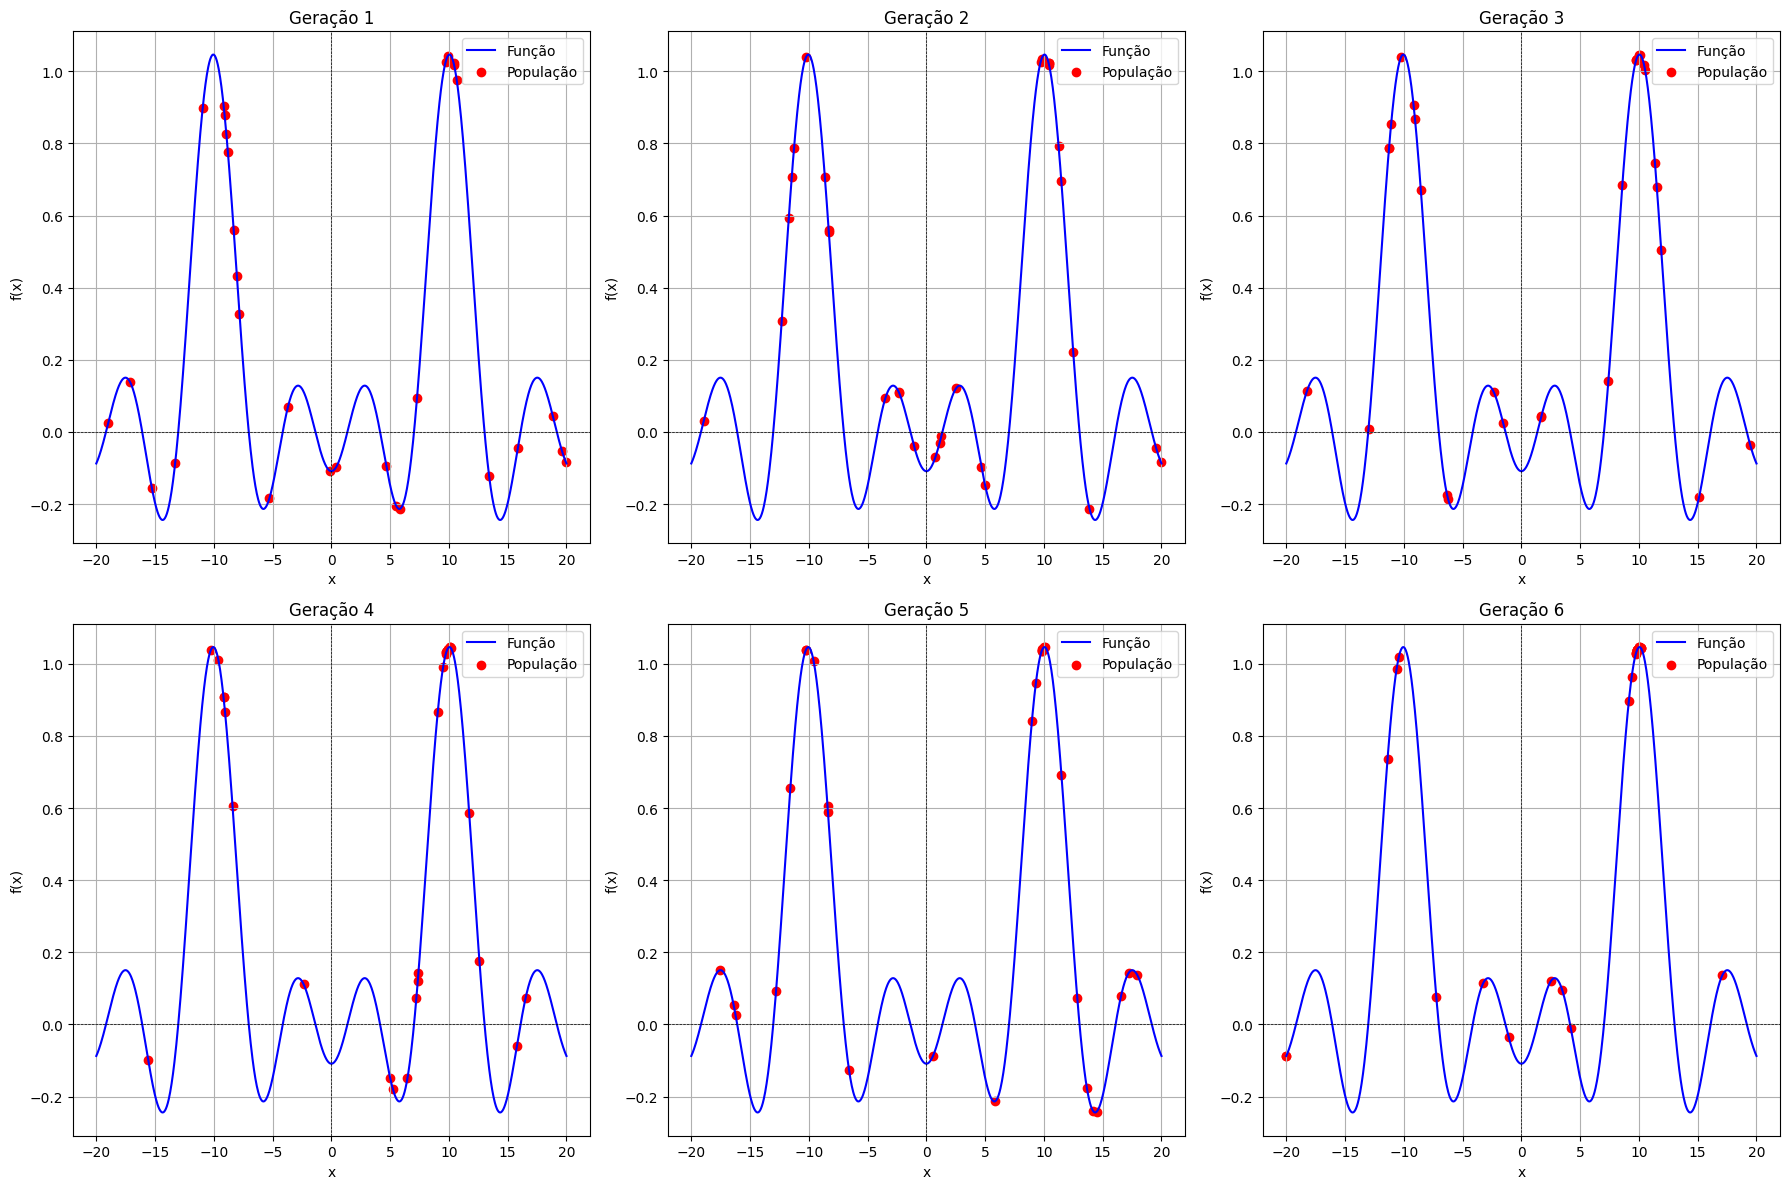

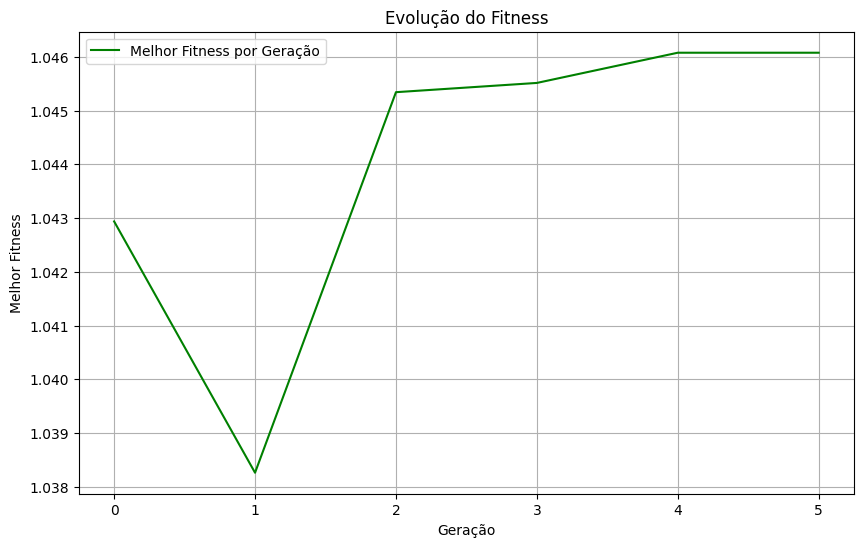

In [7]:
run_ga_deap(function=f, interval=[-20, 20])

## üìå **Descri√ß√£o `run_ga_deap`**

### 1. Defini√ß√µes iniciais

- **Fun√ß√£o objetivo (fitness)**:
  $$
  f: \mathbb{R} \to \mathbb{R}, \quad \text{a ser maximizada.}
  $$

- **Intervalo de busca**:
  $$
  I = [L, H] \subset \mathbb{R}, \quad \text{com } L = -20, \, H = 20.
  $$

- **Tamanho da popula√ß√£o**: $N \in \mathbb{N}$

- **N√∫mero de gera√ß√µes**: $G \in \mathbb{N}$

- **Taxa de crossover**: $p_c \in [0,1]$

- **Taxa de muta√ß√£o**: $p_m \in [0,1]$

- **Elitismo**: $e \in \mathbb{N}$, n√∫mero de melhores indiv√≠duos preservados entre gera√ß√µes.


### 2. Inicializa√ß√£o da popula√ß√£o

Geramos $N$ indiv√≠duos $\{x_1^0, x_2^0, \dots, x_N^0\} \subset [L, H]$ tais que:

$$
x_i^0 \sim \mathcal{U}(L, H)
$$


### 3. Avalia√ß√£o do fitness

Para cada indiv√≠duo $x_i^t$, computa-se:

$$
f_i^t = f(x_i^t)
$$


### 4. Sele√ß√£o por torneio (k = 3)

Para gerar a pr√≥xima gera√ß√£o, aplica-se sele√ß√£o por torneio:

1. Selecionam-se aleatoriamente 3 indiv√≠duos da popula√ß√£o.
2. O indiv√≠duo com maior fitness √© escolhido.

Formalmente, para um subconjunto $S \subset \{1, \dots, N\}$ com $|S| = 3$:

$$
x_{\text{sel}} = \arg\max_{i \in S} f(x_i)
$$


### 5. Crossover blend

Dado dois indiv√≠duos $x_1, x_2 \in \mathbb{R}$, o cruzamento blend (com $\alpha = 0.5$ fixo) gera dois descendentes:

$$
\begin{aligned}
x_{\text{child1}} &= \alpha x_1 + (1 - \alpha)x_2 \\
x_{\text{child2}} &= \alpha x_2 + (1 - \alpha)x_1
\end{aligned}
\quad \text{com } \alpha = 0.5
$$

Este cruzamento √© aplicado com probabilidade $p_c$ para cada par de indiv√≠duos.


### 6. Muta√ß√£o Gaussiana

Cada indiv√≠duo $x$ sofre muta√ß√£o com probabilidade $p_m$, sendo perturbado por ru√≠do gaussiano:

$$
x' = x + \delta, \quad \delta \sim \mathcal{N}(0, \sigma^2)
$$

onde $\sigma = \dfrac{H - L}{10}$. Ap√≥s a muta√ß√£o:

$$
x' \leftarrow \text{clip}(x', L, H)
$$


### 7. Elitismo

Os $e$ melhores indiv√≠duos da popula√ß√£o anterior (com maior valor de $f$) s√£o transferidos diretamente para a nova popula√ß√£o, substituindo os piores indiv√≠duos gerados:

$$
x_1^{t+1}, x_2^{t+1}, \dots, x_e^{t+1} \in \arg\max_{x \in \{x_i^t\}} f(x)
$$


### 8. Itera√ß√£o

Os passos 3 a 7 s√£o repetidos por $G$ gera√ß√µes, produzindo uma nova popula√ß√£o a cada itera√ß√£o.


### 9. Resultado final

Ao final da gera√ß√£o $G$, retorna-se o melhor indiv√≠duo da √∫ltima popula√ß√£o:

$$
x^* = \arg\max_{x \in \{x_i^G\}} f(x)
$$